[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/soloyant/deltax_workshop_2024/blob/main/tutorials/1_HydrodynamicModeling_ANUGA/[2]ANUGA_friction_map_generation.ipynb)

<div style="text-align: center;">
    <img src="notebook_illustrations/deltax_2020.png" alt="Delta-X Logo" style="height: 100px; width: auto; display: inline;">
    <img src="notebook_illustrations/Tribrand_ColorBlack_rgb_16x3_160601.png" alt="JPL Logo" style="height: 100px; width: auto; display: inline;">
</div>
<h1 style="text-align: center;">Delta-X 2024 Application Workshop - May 8, 2024</h1>
<h2 style="text-align: center;">Anuga Hydrodynamic Modeling: Hands On Exercises</h2>
<h2 style="text-align: center;">Part 2/5: Friction Map Generation</h2>

<h3>Author information:</h3>

Antoine Soloy, Ph.D.  
Division 334F, Caltech - Jet Propulsion Laboratory  
4800 Oak Grove Drive, Pasadena, CA, USA  91109-8099  
Contact: antoine.soloy@jpl.nasa.gov

# I - Import packages and define the working directories

In [1]:
import sys

if 'google.colab' in sys.modules:
  # In case the notebook is opened in google collab, here we download/install all the files we need behind the scenes
  try:
      import os
      os.chdir('/content')
      # Grab workbook files into colab directory
      !git clone https://github.com/soloyant/deltax_workshop_2024.git
      # Install everything using some bash scripts
      !/bin/bash /content/deltax_workshop_2024/tutorials/1_HydrodynamicModeling_ANUGA/utils/anuga_tools/install_anuga_colab.sh
      os.chdir('/content/deltax_workshop_2024/tutorials/1_HydrodynamicModeling_ANUGA/')
  except:
      pass

In [2]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
import numpy as np
import os
from scipy import ndimage
from skimage.measure import label
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.morphology import remove_small_holes
from skimage.filters import median
from skimage.morphology import square
from utils import data_processing_tools as dpt

# Define the path to scripts and data
workshop_dir = os.getcwd()
# # Alternatively:
# workshop_dir = '/path/to/1_HydrodynamicModeling_ANUGA'
data_dir = os.path.join(workshop_dir, 'data')
model_inputs_dir = os.path.join(workshop_dir, 'model_inputs')
model_outputs_dir = os.path.join(workshop_dir, 'model_outputs')
if 'google.colab' in sys.modules:
    data_dir = os.path.join(data_dir, 'collab')
    model_inputs_dir = os.path.join(model_inputs_dir, 'collab')
    model_outputs_dir = os.path.join(model_outputs_dir, 'collab')
model_visuals_dir = os.path.join(workshop_dir, 'visuals')
model_validation_dir = os.path.join(workshop_dir, 'validation')

for d in [model_inputs_dir, model_outputs_dir, model_visuals_dir, model_validation_dir]:
    Path(d).mkdir(parents=True, exist_ok=True)
        

# II - Partial classification from water body types

As different bed material and types of land cover do not oppose the same resistence to water flow, it is useful to classify the model cells into groups that will likely behave in various ways. For instance, one can expect large channels to exhibit much less friction than shallow vegetated marshes. For this reason, we need to create a map that will allow us to provide the model with a diversity of friction values.  
To do this, we will first use the water mask to distinguish relevant types of water bodies, including the ocean, and the large and narrow channels. Then, we will use of the vegetation type map and add these groups to our classification.  
The calibration of friction will be performed in the next notebook, right before running the model.

### Datasets citation:
- Christensen, A.L., M.W. Denbina, and M. Simard. 2023. Delta-X: Digital Elevation Model, MRD, LA, USA, 2021. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2181
- Jensen, D.J., E. Castaneda-Moya, E. Solohin, D.R. Thompson, and M. Simard. 2024. Delta-X AVIRIS-NG L3 Derived Vegetation Types, MRD, Louisiana, USA. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2352

In [3]:
# Load background imagery
f_bg_img_tif = os.path.join(data_dir, 'misissippi_S2_background_image.tif')
bg_img_src = rio.open(f_bg_img_tif)
bg_img = np.stack([bg_img_src.read(i) for i in range(1, bg_img_src.count+1)], axis=2)
bg_img_extent = [bg_img_src.bounds.left, bg_img_src.bounds.right,
                 bg_img_src.bounds.bottom, bg_img_src.bounds.top]

# Load water mask
f_water_mask_tif = os.path.join(data_dir, 'DeltaX_MultiSource_DEM_watermask_V1_clipped.tif')
f_centerlines_buffered_tif = os.path.join(data_dir, 'mississippi_River_Centerlines_V1/mississippi_River_Centerlines_V1_buffered.tif')

water_mask_src = rio.open(f_water_mask_tif)
water_mask = water_mask_src.read(1)
water_mask_backup = water_mask.copy()
extent = [water_mask_src.bounds.left, water_mask_src.bounds.right,
          water_mask_src.bounds.bottom, water_mask_src.bounds.top]
resolution =water_mask_src.res[0]
epsg = str(water_mask_src.read_crs())

# Load the centerline-derived artificial water mask
centerlines_water_mask_src = rio.open(f_centerlines_buffered_tif)
centerlines_water_mask = centerlines_water_mask_src.read(1)

# Merge water masks
water_mask = (water_mask + centerlines_water_mask)>=1
water_mask_no_data = water_mask_src.nodatavals[0]
if water_mask_no_data is not None:
    water_mask = np.where(water_mask_backup == water_mask_no_data, np.nan, water_mask)

# Calculate the distance to shoreline
water_mask_noholes = remove_small_holes(water_mask.astype(int), 500, connectivity=2)*1
water_mask_dist = ndimage.distance_transform_edt(water_mask_noholes)


/var/folders/1d/t5vw320n66q_x4h2qkvrf6sw0000gq/T/ipykernel_35052/3477498929.py:31: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  water_mask_noholes = remove_small_holes(water_mask.astype(int), 500, connectivity=2)*1


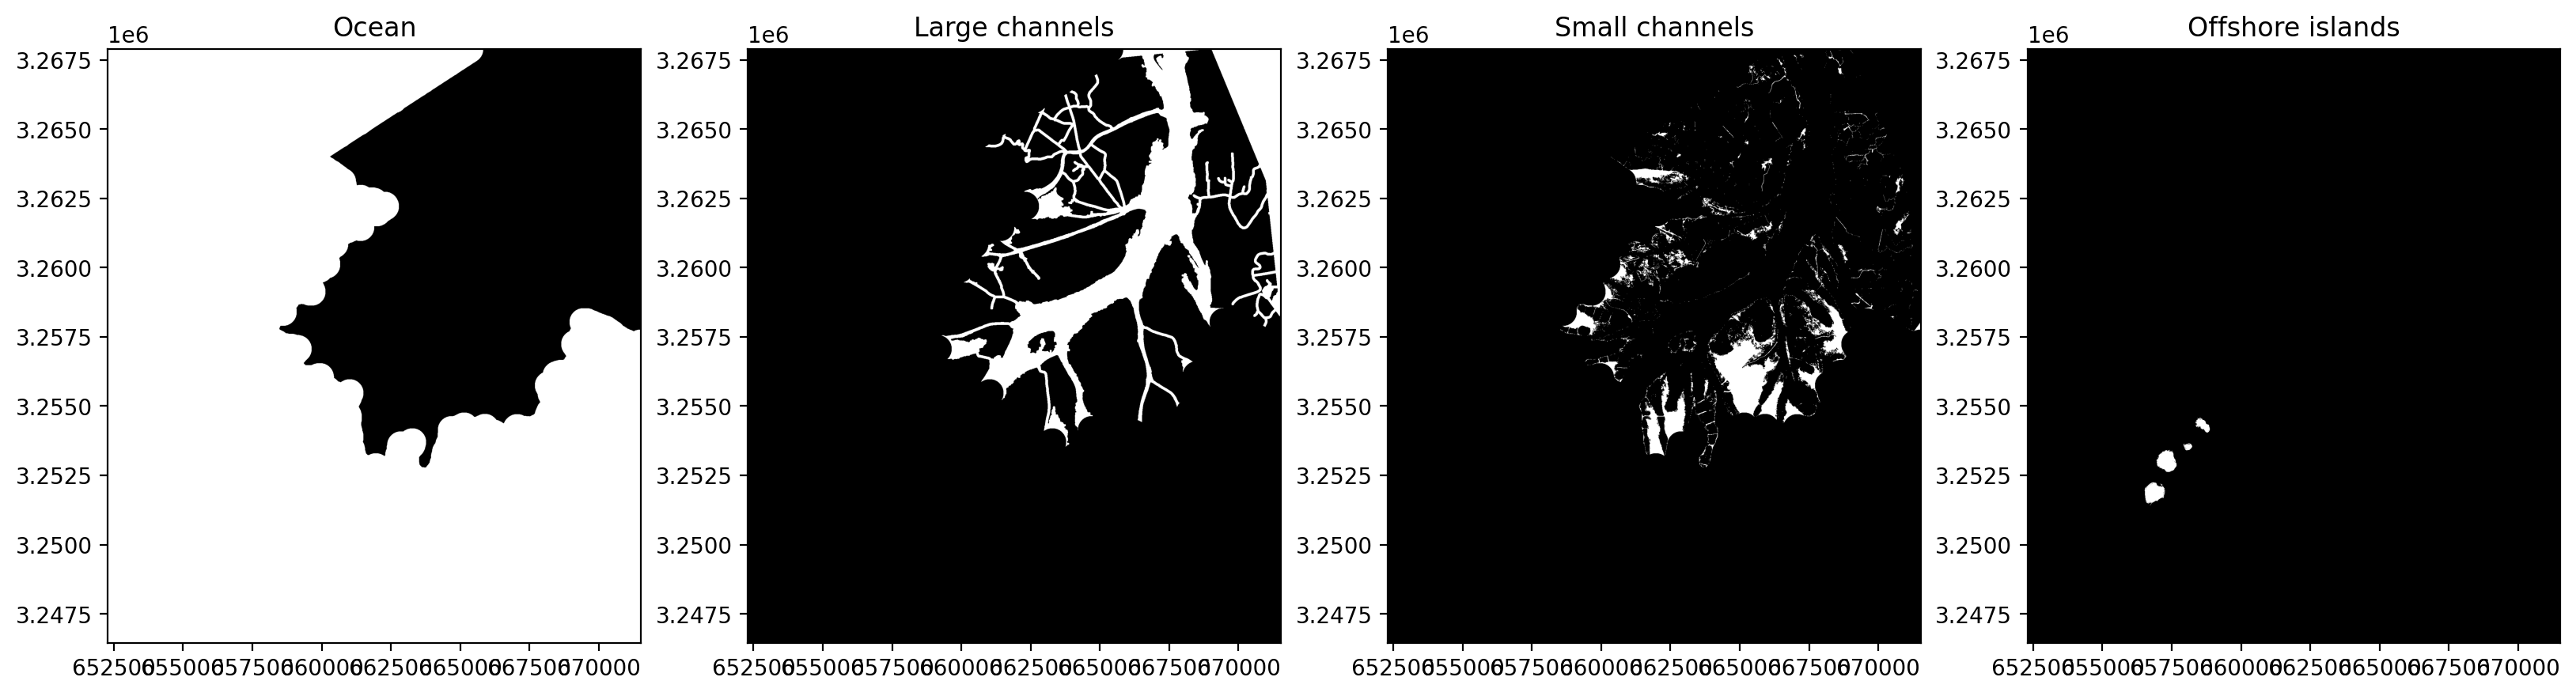

In [4]:
# Identify ocean region
ocean = dpt.find_ocean(water_mask_noholes, water_mask_dist, resolution_m=resolution, buffer_m=500)

# Identify larger channels
large_channels = dpt.find_channels(water_mask_noholes, water_mask_dist, ocean, resolution_m=resolution, ths_m=35)
large_channels = large_channels-ocean
large_channels[large_channels==-1]=0
label_large_channels = label(large_channels) #Additionnal parametric selection
large_channels = (label_large_channels==1)*1

# Identify smaller channels
small_channels = dpt.find_channels_range(water_mask_noholes, water_mask_dist, ocean, resolution_m=resolution, min_ths_m=0, max_ths_m=75)
small_channels = small_channels-ocean-large_channels
small_channels[small_channels<0]=0

# Identify offshore islands
offshore_islands = (water_mask_noholes-ocean-large_channels-small_channels)*-1

# Data visualization
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(20, 5), dpi=200)
ax1.imshow(ocean, extent=extent, cmap='gist_gray')
ax1.set_title('Ocean')

ax2.imshow(large_channels, extent=extent, cmap='gist_gray')
ax2.set_title('Large channels')

ax3.imshow(small_channels, extent=extent, cmap='gist_gray')
ax3.set_title('Small channels')

ax4.imshow(offshore_islands, extent=extent, cmap='gist_gray')
ax4.set_title('Offshore islands')

plt.savefig(os.path.join(model_visuals_dir, 'water_bodies.png'))
plt.show()

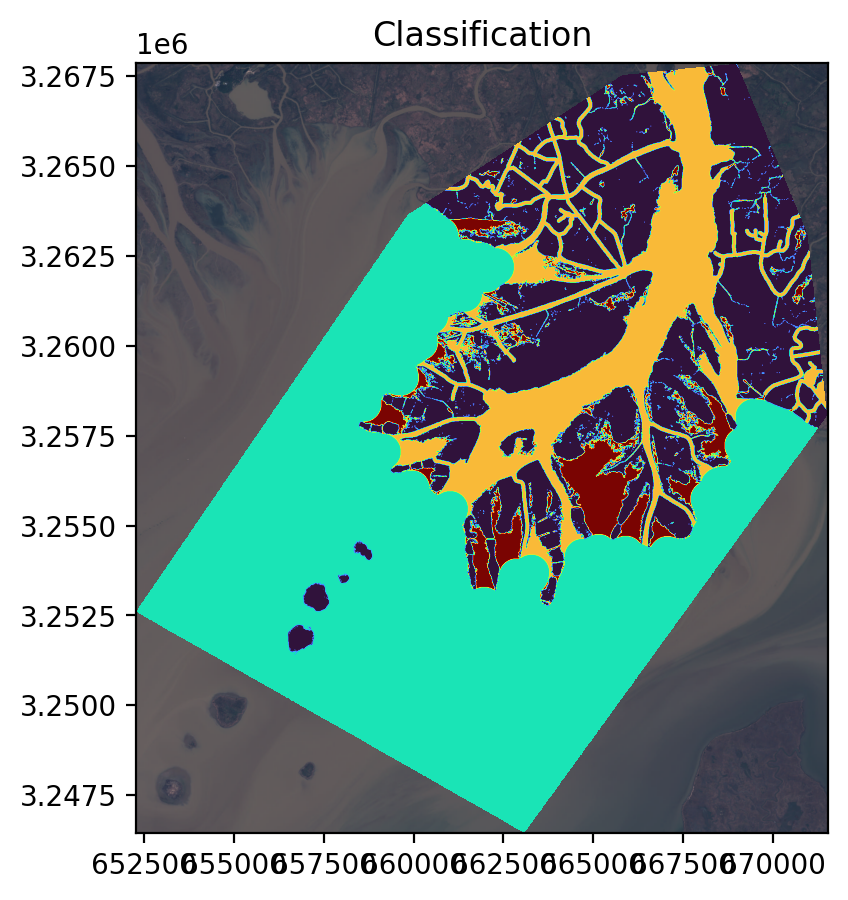

In [5]:
# Build classification map from water bodies
classification = np.zeros(np.shape(water_mask_noholes))
classification[ocean==1]=1
classification[large_channels==1]=2
classification[small_channels==1]=3
classification[offshore_islands==1]=0

# Clip to domain boundaries
if water_mask_no_data is not None:
    classification = np.where(water_mask_backup == water_mask_no_data, np.nan, classification)

# Data visualization
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
ax.imshow(bg_img, extent=bg_img_extent)
ax.imshow(classification, extent=extent, cmap='turbo')
ax.set_title('Classification')

plt.savefig(os.path.join(model_visuals_dir, 'water_body_classification_map.png'))
plt.show()

# III - Complete the classification with vegeration types

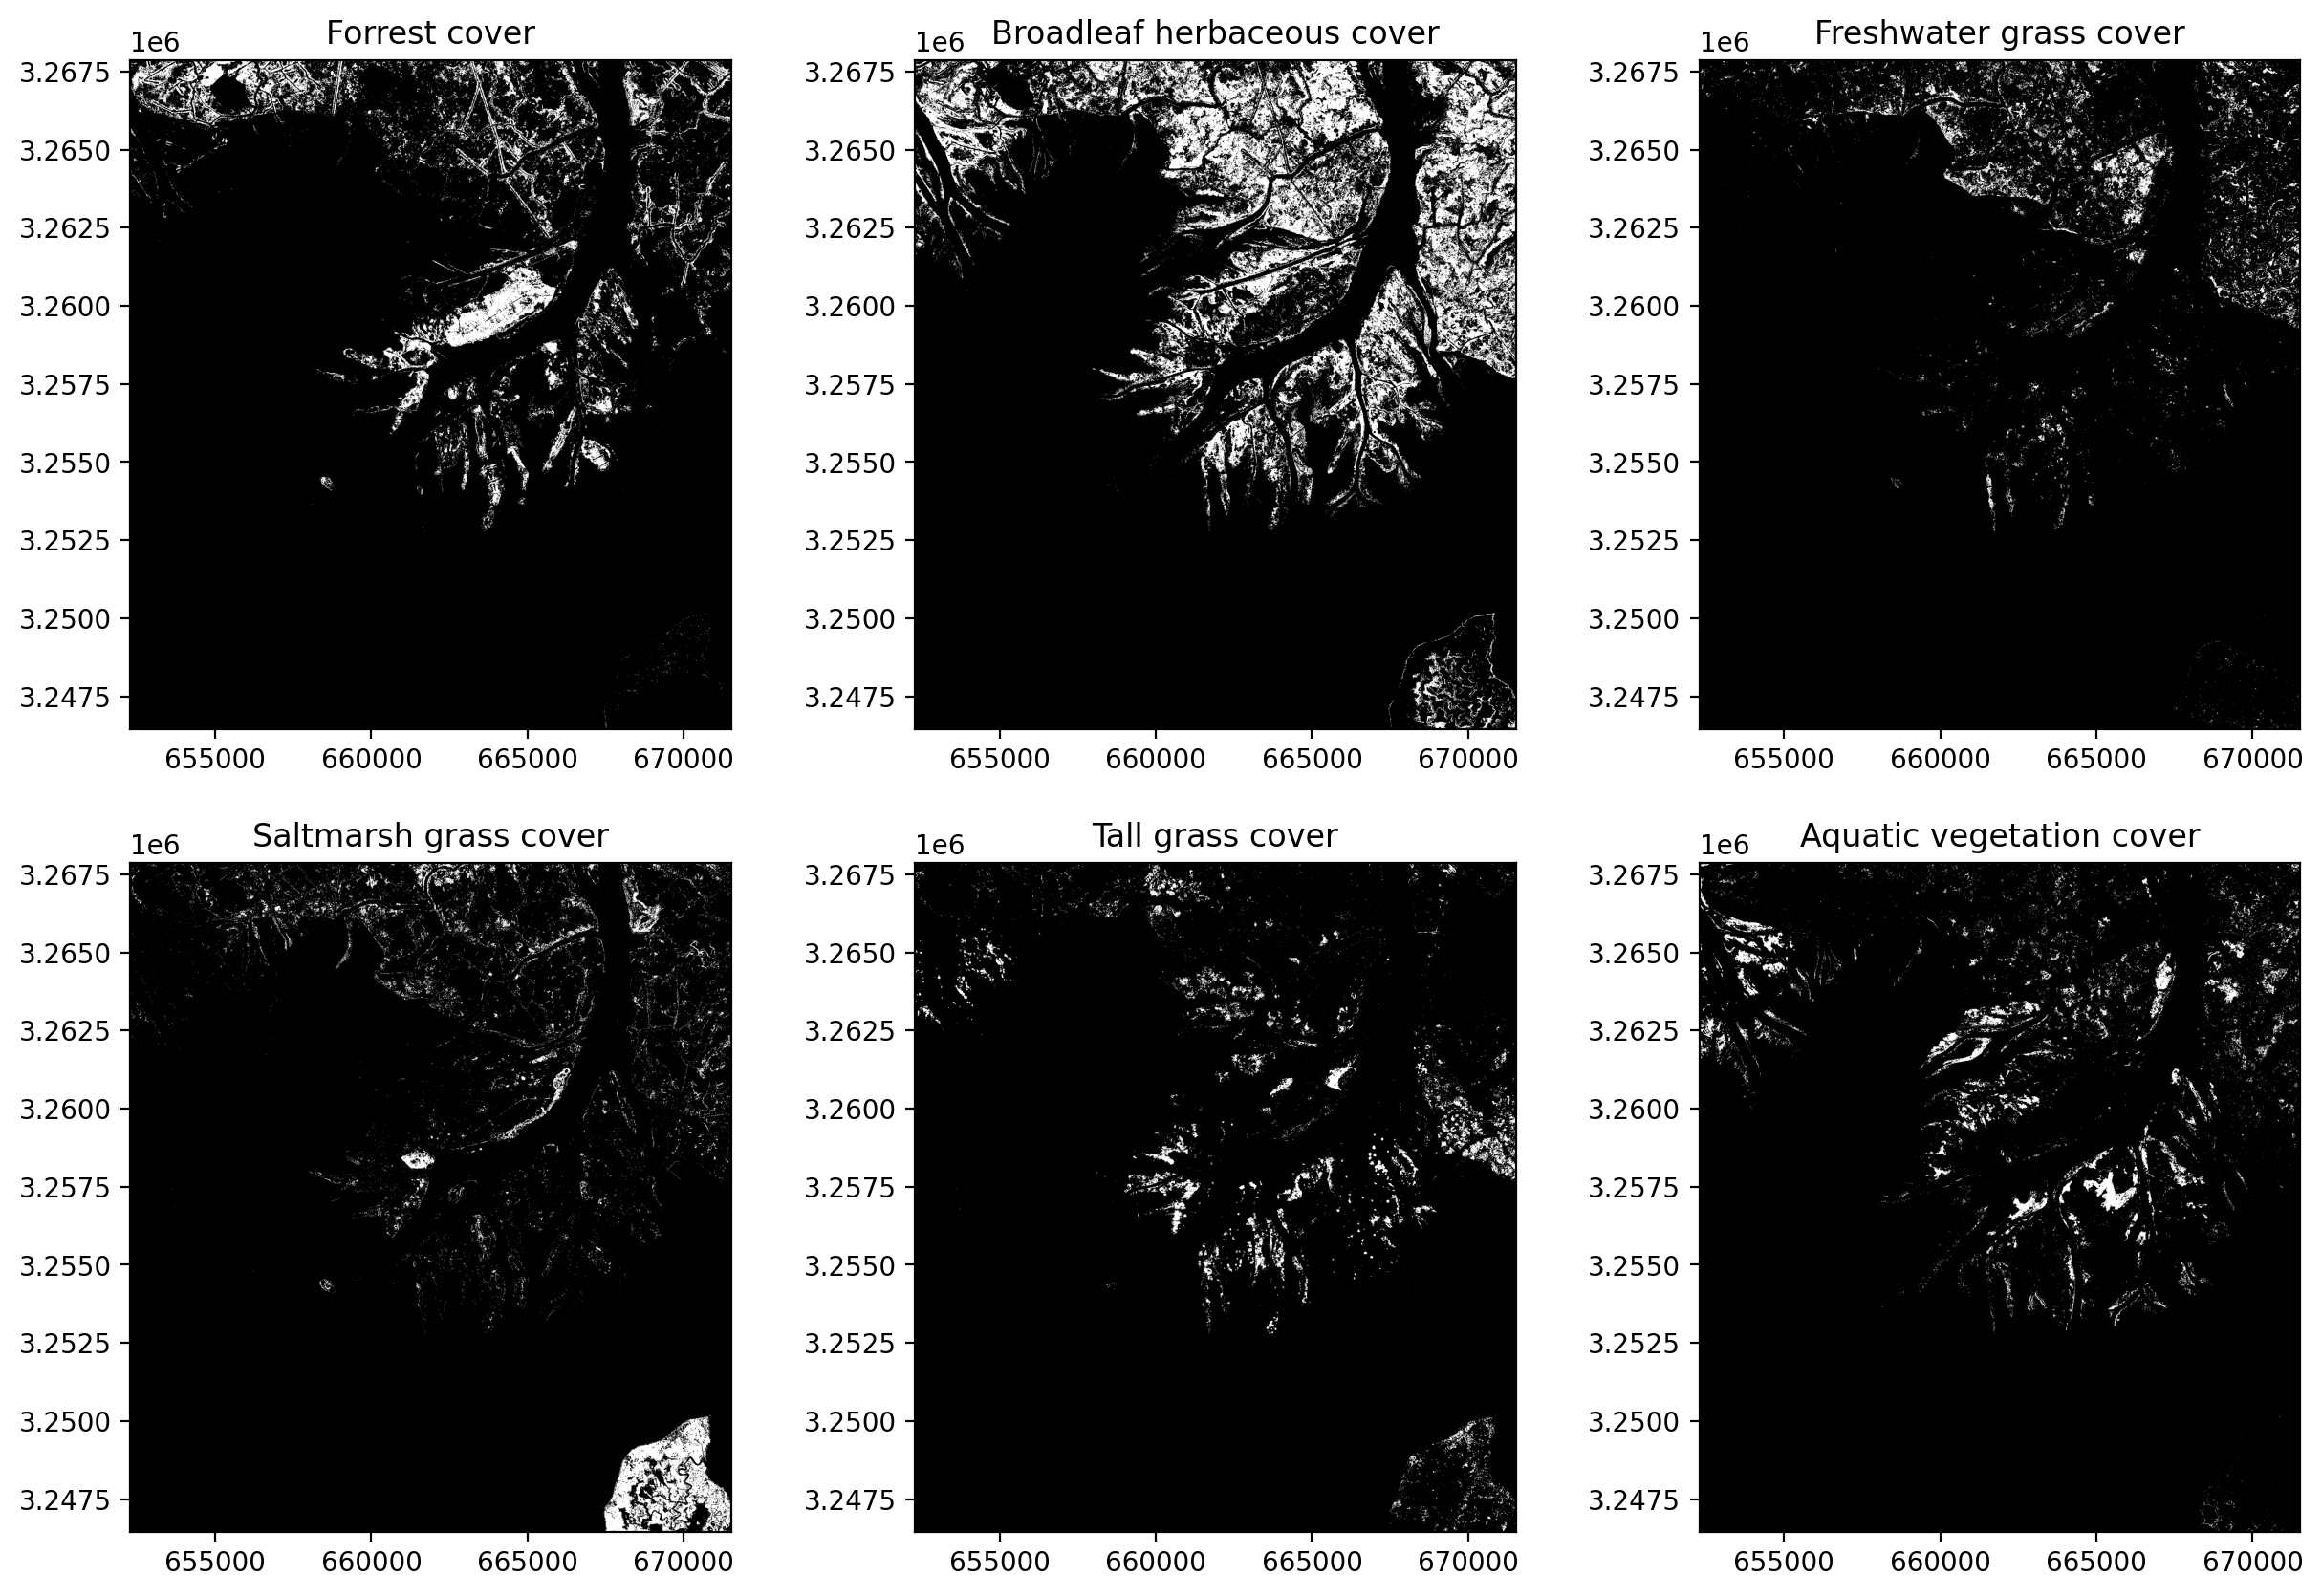

In [6]:
#Align and clip vegetation maps to water mask extent
f_vegcover_tif = os.path.join(data_dir, 'ang20210820-25_VegClass_Combined_resamp10m.tif')
f_vegcover_clipped_tif = f_vegcover_tif.replace('.tif', '_clipped.tif')

if 'google.colab' not in sys.modules:
    dpt.reproj_match(infile = f_vegcover_tif, 
                 match = f_water_mask_tif,
                 outfile = f_vegcover_clipped_tif)

f_vegcover_src = rio.open(f_vegcover_clipped_tif)
vegcover = f_vegcover_src.read(1)

forrest = (vegcover==1) *1
broadleaf_herb = (vegcover==2) *1
freshwater_grass = (vegcover==3) *1
saltmarsh_grass = (vegcover==4) *1
tall_grasses = (vegcover==5) *1
aquatic_veg = (vegcover==6) *1

# Data Visualization
fig, ax = plt.subplots(2, 3, figsize=(15, 10), dpi=200)

ax[0,0].imshow(forrest, extent=extent, cmap='gist_gray')
ax[0,0].set_title('Forrest cover')

ax[0,1].imshow(broadleaf_herb, extent=extent, cmap='gist_gray')
ax[0,1].set_title('Broadleaf herbaceous cover')

ax[0,2].imshow(freshwater_grass, extent=extent, cmap='gist_gray')
ax[0,2].set_title('Freshwater grass cover')

ax[1,0].imshow(saltmarsh_grass, extent=extent, cmap='gist_gray')
ax[1,0].set_title('Saltmarsh grass cover')

ax[1,1].imshow(tall_grasses, extent=extent, cmap='gist_gray')
ax[1,1].set_title('Tall grass cover')

ax[1,2].imshow(aquatic_veg, extent=extent, cmap='gist_gray')
ax[1,2].set_title('Aquatic vegetation cover')

plt.savefig(os.path.join(model_visuals_dir, 'vegetation_types.png'))
plt.show()

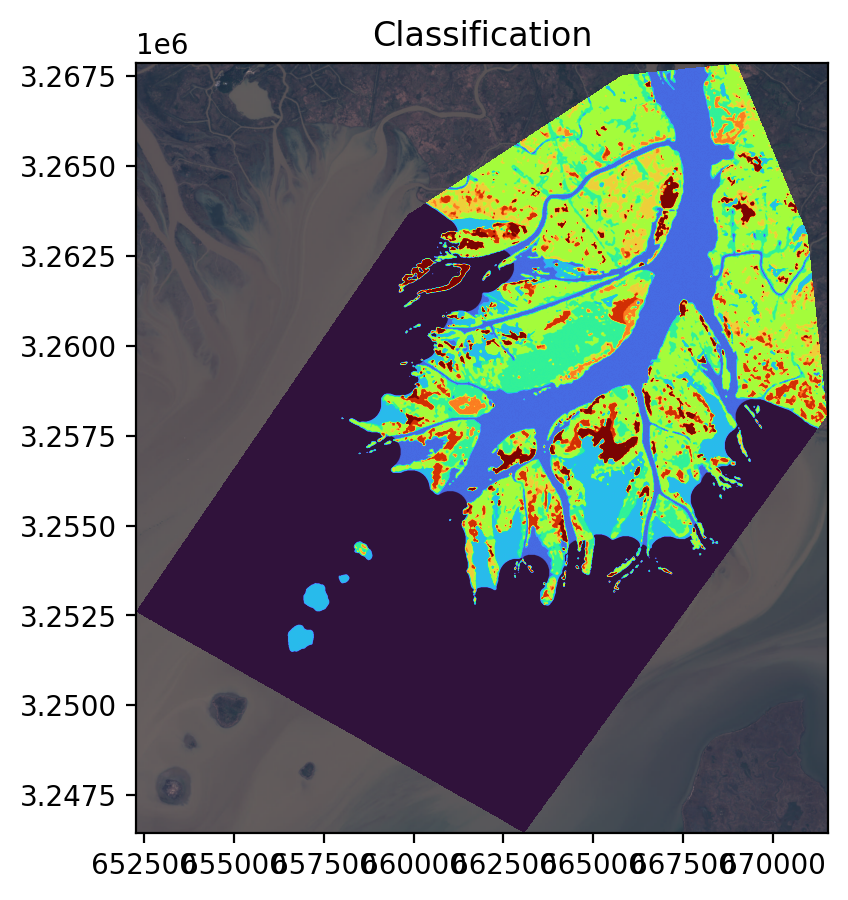

In [7]:
# Add vegetated areas to the classification
classif_including_veg = classification.copy()
classif_including_veg[forrest==1] = 4
classif_including_veg[broadleaf_herb==1] = 5
classif_including_veg[freshwater_grass==1] = 6
classif_including_veg[saltmarsh_grass==1] = 7
classif_including_veg[tall_grasses==1] = 8
classif_including_veg[aquatic_veg==1] = 9

# Remaining pixels are set to small channels values to allow flow of water
classif_including_veg[np.isnan(classif_including_veg)] = 3 
classif_including_veg[classif_including_veg==0] = 3 

# A median filter is applied to denoise the map
classif_including_veg = median(classif_including_veg, square(7))

# Clip to domain boundaries
if water_mask_no_data is not None:
    classif_including_veg = np.where(water_mask_backup == water_mask_no_data, np.nan, classif_including_veg)

# Data visualization
fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
ax.imshow(bg_img, extent=bg_img_extent)
ax.imshow(classif_including_veg, extent=extent, cmap='turbo')
ax.set_title('Classification')

plt.savefig(os.path.join(model_visuals_dir, 'friction_classification_map.png'))
plt.show()

# IV - Save the results

In [8]:
# Saving model input
f_friction_classes_tif = os.path.join(model_inputs_dir, 'friction_classes.tif')

with rio.open(f_friction_classes_tif, 'w', driver='GTiff', 
              height=water_mask_src.height, width=water_mask_src.width, count=1, dtype=water_mask.dtype, 
              crs=epsg, transform=water_mask_src.transform, compress="LZW", nodata=-9999) as raster_file:
    raster_file.write(classif_including_veg, 1)
    